In [30]:
import pandas as pd
import geopandas as gpd
import rasterio
import rasterio.features
import rasterio.warp
from rasterio.plot import show
#Importing the Nominatim geocoder class 
#from geopy.geocoders import Nominatim
from shapely.geometry import point, Polygon
import rioxarray
from pyproj import CRS
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
import requests
from osgeo import gdal
from osgeo import ogr
import fiona
%matplotlib inline
from shapely.geometry import Polygon
import shapefile

from rasterio.mask import mask


In [6]:
address = input('Provide a valid address in Flanders: ')
#Heikantstraat 124, 2910 Essen
#Epicealaan 28, 2910 Essen
#Moerkantsebaan 34, 2910 Essen
#Maststraat 2, 2910 Essen

Provide a valid address in Flanders: Epicealaan 28, 2910 Essen


In [7]:
# get a polygoon based on address in Flanders

def get_coordinates(address: str):
    req = requests.get(f"https://loc.geopunt.be/v4/Location?q={address}").json()
    info = {'address' : address, 
                'x_value' : req['LocationResult'][0]['Location']['X_Lambert72'],
                'y_value' : req['LocationResult'][0]['Location']['Y_Lambert72'],
                'street' : req['LocationResult'][0]['Thoroughfarename'],
                'house_number' : req['LocationResult'][0]['Housenumber'], 
                'postcode': req['LocationResult'][0]['Zipcode'], 
                'municipality' : req['LocationResult'][0]['Municipality']}
    
    detail = requests.get("https://api.basisregisters.vlaanderen.be/v1/adresmatch", 
                          params={"postcode": info['postcode'], 
                                  "straatnaam": info['street'],
                                  "huisnummer": info['house_number']}).json()
    building = requests.get(detail['adresMatches'][0]['adresseerbareObjecten'][0]['detail']).json()
    build = requests.get(building['gebouw']['detail']).json()
    info['polygon'] = [build['geometriePolygoon']['polygon']]
    return info['polygon'][0]['coordinates'][0] 

In [8]:
# store polygon in a variable
polygon = get_coordinates(address)

In [9]:
x_polygon = [i[0] for i in polygon]

In [10]:
y_polygon = [i[1] for i in polygon]

In [11]:
# convert polygon to a Shapely format
polygon_shapely = Polygon(polygon)

# save a polygon to a .shp file
w = shapefile.Writer('shapefiles/polygon')
w.field('name', 'C')

w.poly([polygon])
w.record('polygon1')

w.close()

In [12]:
polygon_path = 'C:/Users/kasia/pyproj/3D_houses/shapefiles/polygon.shp'

In [13]:
# calculate bounds of a rectangle that contains the polygon
left = min(x_polygon)
right = max(x_polygon)
top = max(y_polygon)
bottom = min(y_polygon)
# print(f"left = {left}, right = {right}, top = {top}, bottom = {bottom}")

In [14]:
type(left)

float

In [15]:
# create a rectangle which contains the polygoon (left,bottom, right, top)

In [16]:
polygon_bounds = [[left,bottom, right, top]]
polygon_bounds

[[155541.3664790839,
  238539.7295114845,
  155558.52071909606,
  238557.83306349814]]

In [17]:
# find to which file belong polygon_bounds - loop over the the DTM_bounds.csv

In [18]:
df = pd.read_csv('DTM_bounds.csv')

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43 entries, 0 to 42
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   url_dtm  43 non-null     object 
 1   url_dsm  43 non-null     object 
 2   left     43 non-null     float64
 3   right    43 non-null     float64
 4   top      43 non-null     float64
 5   bottom   43 non-null     float64
dtypes: float64(4), object(2)
memory usage: 2.1+ KB


In [26]:
df.head()

,url_dtm,url_dsm,left,right,top,bottom
0,zip+https://downloadagiv.blob.core.windows.net...,zip+https://downloadagiv.blob.core.windows.net...,145000.0,162000.0,247000.0,238000.0
1,zip+https://downloadagiv.blob.core.windows.net...,zip+https://downloadagiv.blob.core.windows.net...,162000.0,194000.0,250000.0,238000.0
2,zip+https://downloadagiv.blob.core.windows.net...,zip+https://downloadagiv.blob.core.windows.net...,194000.0,206000.0,248000.0,238000.0
3,zip+https://downloadagiv.blob.core.windows.net...,zip+https://downloadagiv.blob.core.windows.net...,53000.0,66000.0,225500.0,218000.0
4,zip+https://downloadagiv.blob.core.windows.net...,zip+https://downloadagiv.blob.core.windows.net...,66000.0,98000.0,232000.0,218000.0


In [34]:
for index, row in df.iterrows():
    if left >= row.left and right <= row.right and top <= row.top and bottom >= row.bottom:
        right_dtm_url = row.url_dtm
        right_dsm_url = row.url_dsm
print(right_dsm_url)       
print(right_dtm_url)         

zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dsm-raster-1m/DHMVIIDSMRAS1m_k01.zip!/GeoTIFF/DHMVIIDSMRAS1m_k01.tif
zip+https://downloadagiv.blob.core.windows.net/dhm-vlaanderen-ii-dtm-raster-1m/DHMVIIDTMRAS1m_k01.zip!/GeoTIFF/DHMVIIDTMRAS1m_k01.tif


In [43]:
# clip DSM file with rasterio
with fiona.open("C:/Users/kasia/pyproj/3D_houses/shapefiles/polygon.shp", "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

with rasterio.open(right_dsm_url) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("C:/Users/kasia/pyproj/3D_houses/DSM_clip.tif", "w", **out_meta) as dest:
    dest.write(out_image)    

In [44]:
# clip DTM file with rasterio
with rasterio.open(right_dtm_url) as src:
    out_image, out_transform = rasterio.mask.mask(src, shapes, crop=True)
    out_meta = src.meta
    
out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

with rasterio.open("C:/Users/kasia/pyproj/3D_houses/DTM_clip.tif", "w", **out_meta) as dest:
    dest.write(out_image)  

In [45]:
DSM_clip = rioxarray.open_rasterio("C:/Users/kasia/pyproj/3D_houses/DSM_clip.tif", masked = True)

In [46]:
DTM_clip = rioxarray.open_rasterio("C:/Users/kasia/pyproj/3D_houses/DTM_clip.tif", masked = True)

In [47]:
CHM_clip = DSM_clip - DTM_clip

In [51]:
CHM_clip = CHM_clip.fillna(0)

In [52]:
CHM_clip_padded = np.pad(CHM_clip, pad_width=1)

In [55]:
CHM_clip_padded.shape

(3, 21, 20)

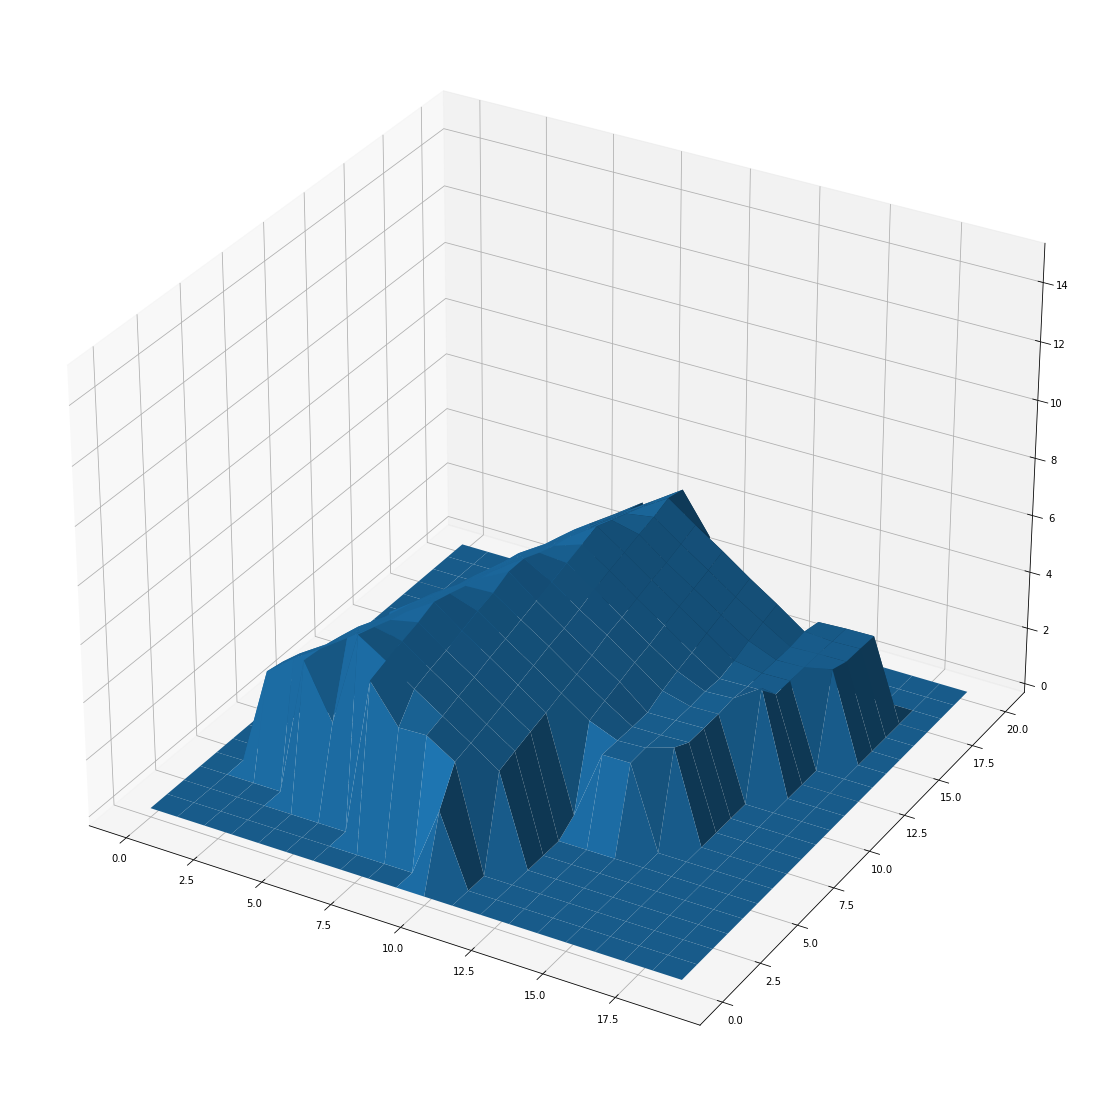

In [61]:
# initialize figure and axes3D objects
hf = plt.figure(figsize = (20,20))
ha = hf.add_subplot(111, projection='3d')

# plotting the 3D data
X, Y = np.meshgrid(np.arange(20), np.arange(21))
ha.plot_surface(X, Y, CHM_clip_padded[1])
ha.set_zlim(0,15)
plt.show()